# Groupby and Arrest Data

<span style="color: #008080">*Jiechen Li & Joanna Nowakowska*</span>

In our merging exercises, we examined the relationship between county-level violent arrest totals and county-level drug arrest totals. In those exercises, you were given a dataset that provided you with county-level arrest totals. But that's not actually how the data is provided by the state of California. This week we will work with the *raw* California arrest data, which is not organized by county or even county-year. 



## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_groupby.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex4_num_rows",
    "ex5_collapsed_vars",
    "ex7_alameda_1980_share_violent_arrestees_black",
    "ex11_white_drug_share",
    "ex11_black_drug_share",
    "ex12_proportionate",
}
```


### Submission Limits

Please remember that you are **only allowed three submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.

### Exercise 1

Import the raw California arrest data from the State Attorney General's office. Please use [this link](https://github.com/nickeubank/MIDS_Data/blob/master/OnlineArrestData1980-2021.csv) (the original is here [here](https://openjustice.doj.ca.gov/data), but they keep updating it and I get tired of updating solutions, so... please use my copy!)

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

data_1 = (
    "https://github.com/nickeubank/MIDS_Data/raw/master/OnlineArrestData1980-2021.csv"
)

arrests = pd.read_csv(data_1)

## Learning the Group Structure of Your Data

### Exercise 2

What is the unit of observation for this dataset? In other words, when row zero says that there were 505 arrests for `VIOLENT` crimes, what exactly is that telling you—505 arrests in 1980? 505 arrests in Alameda County?

(Please answer in Markdown)

In [2]:
arrests.head()

,YEAR,GENDER,RACE,AGE_GROUP,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
0,1980,Male,Black,Under 18,Alameda County,505,1351,188,26,79,2149,2286,295
1,1980,Male,Black,18 to 19,Alameda County,205,465,183,8,48,909,1333,0
2,1980,Male,Black,20 to 29,Alameda County,949,1593,606,27,178,3353,7974,0
3,1980,Male,Black,30 to 39,Alameda County,450,755,241,18,110,1574,4876,0
4,1980,Male,Black,40 to 69,Alameda County,172,218,117,11,66,584,3836,0


<span style="color: #008080">**Exercise 2 Answer**

<span style="color: #008080">Each row describes the distribution of arrests in the given year for a specified group of people(by gender, race, age) in the chosen county.</span> 

### Testing Your Assumptions

It's important to be able to test whether the data you are working with really is organized the way you think it is, especially when working with groupby. Let's discuss how to check your answer to Exercise 2 with the `.duplicated()` method. 

Consider the following toy data:

In [3]:
import pandas as pd

df = pd.DataFrame(
    {
        "social_security_numbers": [
            111111111,
            222222222,
            222222222,
            333333333,
            333333333,
        ],
        "second_column": ["a", "a", "a", "a", "b"],
    }
)
df

,social_security_numbers,second_column
0,111111111,a
1,222222222,a
2,222222222,a
3,333333333,a
4,333333333,b


If we want to see if there are any duplicate rows in the dataset, we can use the `.duplicated()` method:

In [4]:
df.duplicated()

0    False
1    False
2     True
3    False
4    False
dtype: bool

As you can see, `.duplicated()` looks at each row and returns `True` if it has seen the row it is looking at before. 

Notice that `.duplicted()` doesn't return `True` for *all* rows that look the same as another row in the data—it treats the first instance of a row as unique, and only tags *subsequent* repetitions as "duplicates" (You can change this behavior with the `keep` keyword argument if you want).

`.duplicated()` can also be used to test for rows that are duplicates in terms of a sub-set of columns. For example, `df.duplicated(["social_security_numbers"])` identifies rows with duplicate values of the variable `social_security_numbers`:

In [5]:
df.duplicated(["social_security_numbers"])

0    False
1    False
2     True
3    False
4     True
dtype: bool

Since `duplicated` is now only looking at `social_security_numbers` (not all values in a row), the last row is now a duplicate (because `333333333` is duplicated), where when we considered all columns, it was not a duplicate. 

### Testing with .duplicated()

`.duplicated()` can be paired with the `.any()` method to write `assert` tests to detect the presence of duplicates in our dataset and to validate our assumptions about whether certain variables uniquely identify observations in our data.

When you run `.any()` on an array of Booleans, it returns a single value of `True` if *any* entries are `True`, and a single value of `False` if *no* entries are `True`. (You can also use `.all()` to test if all entries are `False`).

Thus the command `df.duplicated(['social_security_numbers'])` will return `False` if `social_security_numbers` uniquely identifies every row in our dataset (since there are no duplicates)! But if there *are* any duplicates, it will return `True`:

In [6]:
# df.duplicated(["social_security_numbers"]).any()

So if I wanted a test that would raise an `Error` if it turned out that `social_security_numbers` *didn't* uniquely identify observations, I would combine that code with `assert not`:

```python
assert not df.duplicated(["social_security_numbers"]).any()

---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In [20], line 1
----> 1 assert not df.duplicated(["social_security_numbers"]).any()

AssertionError: 
```

(which in this case raises an Error because `social_security_numbers` *isn't* unique!)

BTW, if this feels oddly familiar, that's probably because we talked about this same idea when discussing merging. A `1:1` merge is one in which the merging variables uniquely identify observations in both datasets.

### Exercise 3

Use `duplicated` to test if the variables *you* think uniquely identify rows in your data really do uniquely identify rows. If you were wrong, update your beliefs (and your code) until you have an `assert` statement that passes.

In [7]:
arrests.duplicated().any()

False

<span style="color: #008080">``False`` means there are no completely duplicated rows in arrests DataFrame, which is a good sign indicating that the data does not have redundancy.

In [8]:
columns = ["YEAR", "COUNTY", "GENDER", "RACE", "AGE_GROUP"]
duplicates = arrests.duplicated(subset=columns).any()
duplicates

False

<span style="color: #008080">The result ``False`` indicates no duplicate rows based on the selected columns "YEAR", "COUNTY", "GENDER", "RACE", and "AGE_GROUP", confirming each record in the dataset is unique.

In [9]:
assert not arrests.duplicated(subset=columns).any()

<span style="color: #008080">We don't see any error message, that means the assertion passed, and there are no duplicate rows based on the specified columns. 

### Exercise 4

Once you have a handle on how the data looks now, please **collapse the data** to be one observation per county-year-racial group. Store the number of rows in the resulting dataframe in your `results` dictionary under the key `"ex4_num_rows"`.

**Hint:** Think carefully about the most appropriate *aggregation function* (e.g., mean, median, sum, count) given the data we're working with!

**Hint 2:** When using `groupby`, I am a HUGE fan of the `as_index=False` keyword argument (e.g., `df.groupby("col1", as_index=False).mean()`). By default when you use groupby, pandas likes to make a new index out of the grouping columns. As you know, I HATE indices, and this keyword argument prevents pandas from this behavior. To illustrate:

In [10]:
df = pd.DataFrame(
    {
        "social_security_numbers": [
            111111111,
            222222222,
            222222222,
            222222222,
            333333333,
        ],
        "second_column": ["a", "a", "b", "a", "b"],
        "third_column": [100, 200, 300, 400, 500],
    }
)
df

,social_security_numbers,second_column,third_column
0,111111111,a,100
1,222222222,a,200
2,222222222,b,300
3,222222222,a,400
4,333333333,b,500


In [11]:
# Without as_index=False
df.groupby(["social_security_numbers", "second_column"]).mean()

third_column
social_security_numbers second_column              
111111111               a                     100.0
222222222               a                     300.0
                        b                     300.0
333333333               b                     500.0

In [12]:
# With as_index=False
df.groupby(["social_security_numbers", "second_column"], as_index=False).mean()

,social_security_numbers,second_column,third_column
0,111111111,a,100.0
1,222222222,a,300.0
2,222222222,b,300.0
3,333333333,b,500.0


In [13]:
# groupby
grouped_data = arrests.groupby(["YEAR", "COUNTY", "RACE"], as_index=False).sum()

results = {}
ex4_num_rows = grouped_data.shape[0]  # confusion with iloc
results["ex4_num_rows"] = ex4_num_rows

print(
    f"Collapsed the data to be one observation per county-year-racial group, the dataframe contains {(ex4_num_rows):} rows."
)

Collapsed the data to be one observation per county-year-racial group, the dataframe contains 9702 rows.


### Exercise 5

You should notice that there are significantly fewer rows in the data now. Given your answer from 3, what groups were you *collapsing* in question 4 (in other words, which different groups were previously split out into separate rows but have now been aggregated into the same rows)?

Store the names of those variables **in a `list` in alphabetical order** in `results` as `"ex5_collapsed_vars"`.

<span style="color: #008080">In Exercise 3, we found that the combination of "YEAR", "COUNTY", "GENDER", "RACE", and "AGE_GROUP" uniquely identified each row in the dataset. However, in Exercise 4 we collapsed the data to one observation per county-year-racial group. This means that the data was combined so that each row represents a combination of county, year, and racial group, regardless of the different genders and ages within those groups.

In [14]:
list_age_gender = sorted(["AGE_GROUP", "GENDER"])
results["ex5_collapsed_vars"] = list_age_gender
results

{'ex4_num_rows': 9702, 'ex5_collapsed_vars': ['AGE_GROUP', 'GENDER']}

## Racial Arrest Composition

The next question we want to ask is: does the racial composition of arrests in each county vary by arrest type? In other words, do Blacks, Hispanics, Whites, and Other make up substantially different portions of the people arrested for drug offenses and violent offenses?

To answer this question, we need to be able to say what proportion of all drug arrestees were Black/White/Hispanic/Other and what proportion of all violent arrestees were Black/White/Hispanic/Other *for each county and for each year*.

In trying to do this, we'll need to break the problem down into pieces, starting from our goal (these quantities) and working backwards.

### Exercise 6

To calculate the share of all drug and violent arrestees who come from each racial group, what quantities do we need? 

Expressed differently, what two variables (one for drug arrests, one for violent arrests) do we need to add to our data to it allow us to calculate the share of arrestees in each county-year that come from a given racial group?

Calculate these two variables (one variable for drug arrests, one for violent arrests). 

**Hint:** `transform` should probably make an appearance here.

**Hint:** This types of groupby manipulations are an easy place to do things wrong, so it's important to eye-ball your data to be sure you did things right! 

Take a look at the data for, say, Alameda County in 1980, and compare the values that you calculate above with what you get if you try to calculate those same numbers by hand using the raw data from Exercise 5?

In [15]:
# groupby county and year, calculate the sum of drug arrests and violent arrests
grouped_data["total_drug_arrests"] = grouped_data.groupby(["COUNTY", "YEAR"])[
    "F_DRUGOFF"
].transform("sum")
grouped_data["total_violent_arrests"] = grouped_data.groupby(["COUNTY", "YEAR"])[
    "VIOLENT"
].transform("sum")

# share of drug and violent arrests for each race
grouped_data["share_drug_arrests"] = (
    grouped_data["F_DRUGOFF"] / grouped_data["total_drug_arrests"]
)
grouped_data["share_violent_arrests"] = (
    grouped_data["VIOLENT"] / grouped_data["total_violent_arrests"]
)

### Exercise 7

Now calculate the share of violent and drug arrestees in each county and year from each racial group.

To ensure you're on the right track, store the share (between zero and one) of violent arrestees in Alameda County in 1980 who were Black as `ex7_alameda_1980_share_violent_arrestees_black`.

In [16]:
# filter Alameda in 1980
alameda_1980 = grouped_data[
    (grouped_data["COUNTY"] == "Alameda County") & (grouped_data["YEAR"] == 1980)
]

# share of black violent arrests
share_black_arrests = alameda_1980[alameda_1980["RACE"] == "Black"][
    "share_violent_arrests"
].iloc[0]

results["ex7_alameda_1980_share_violent_arrestees_black"] = share_black_arrests
results

{'ex4_num_rows': 9702,
 'ex5_collapsed_vars': ['AGE_GROUP', 'GENDER'],
 'ex7_alameda_1980_share_violent_arrestees_black': 0.5759325044404974}

### Exercise 8

We're about to start studying this data by plotting the share of violent arrestees that are Black against the share of felony drug arrestees that are Black. But the moment where you finish your data manipulations and are about to start you data analysis is a *great* time to just make sure everything in your data looks good. Let's run a few checks:

- Are your values of the share of felony arrestees who were arrested for violent crimes sensible?
- You're about to analyze the data using only the rows for the Black racial group. How many unique counties are there with data for Black arrestees? How many for White arrestees? Do you remember how many counties there are in CA (google is your friend if not!)?

Include assert statements to check all these features of your data.

(Reminder: the autograder will only work if you are entire notebook runs without errors.)

If you encounter any problems, make sure you understand why they are happening, and fix them (if a fix is appropriate!).

In [17]:
assert grouped_data[grouped_data["RACE"] == "Black"]["share_violent_arrests"].all() <= 1
assert grouped_data[grouped_data["RACE"] == "Black"]["share_violent_arrests"].all() >= 0

assert grouped_data[grouped_data["RACE"] == "Black"]["share_drug_arrests"].all() >= 0
assert grouped_data[grouped_data["RACE"] == "Black"]["share_drug_arrests"].all() <= 1

In [18]:
black_group = grouped_data[grouped_data["RACE"] == "Black"]["COUNTY"].unique()
len(black_group)
white_group = grouped_data[grouped_data["RACE"] == "White"]["COUNTY"].unique()
len(white_group)

print(len(black_group))
print(len(white_group))

58
58


<span style="color: #008080">There are 58 counties in CA, and our results show that we have data for both black and white racial group in all of the CA counties.

### Exercise 9

Now check to see if you have the same number of counties *in each year for each racial group*.

Can you figure out why there aren't? (Hint: this isn't trivial to figure out! You'll probably have to do some detective work, and even then you'll have to make a bit of a "best guess" at what's going on!)

In [20]:
# in each year-race group is the same or not
# grouped_new = arrests.groupby(["YEAR", "RACE"], as_index=False)["COUNTY"].nunique()[
#     ["COUNTY"]
# ]
grouped_new = arrests.groupby(["YEAR", "RACE"], as_index=False)["COUNTY"].nunique()
distribution = grouped_new.pivot(index="YEAR", columns="RACE", values="COUNTY")

# assert not ((grouped_new["COUNTY"]) == grouped_new["COUNTY"].iloc[0]).all()


# grouped_new.head(5)
distribution

RACE,Black,Hispanic,Other,White
YEAR,,,,
1980,55,57,58,58
1981,55,57,58,58
1982,55,57,58,58
1983,57,58,58,58
1984,55,57,58,58
1985,57,57,58,58
1986,55,57,58,58
1987,55,58,58,58
1988,57,58,58,58


<span style="color: #008080">The reason why there are different numbers of counties in each year for each racial group is because there are some of very small counties with very low number of total arrests (and usually they don't have arrests for each racial group in each year). And over the years the geografical distribution might be changed. 

### Exercise 10

Once you think you have a theory of the case, fix the problem. Again, this will NOT be trivial.

In [21]:
filter_df = grouped_data[
    [
        "YEAR",
        "COUNTY",
        "RACE",
        "total_drug_arrests",
        "total_violent_arrests",
        "share_drug_arrests",
        "share_violent_arrests",
    ]
]
years = filter_df["YEAR"].unique()
races = filter_df["RACE"].unique()
counties = filter_df["COUNTY"].unique()

template = pd.DataFrame(
    [(year, race, county) for year in years for race in races for county in counties],
    columns=["YEAR", "RACE", "COUNTY"],
)

# Merge the template DataFrame with existing data, filling in missing values with 0
merged_df = pd.merge(
    template, filter_df, on=["YEAR", "COUNTY", "RACE"], how="left", indicator=True,
).fillna(0)

### Exercise 11

Now that you have corrected your problem, averaging over the values for each county-year, calculate the average share of drug arrestees who are Black and the average share of drug arrestees who are White. Store the results as `"ex11_white_drug_share"` and `"ex11_black_drug_share"`.

In [22]:
ex11_black_drug_share = merged_df[merged_df["RACE"] == "Black"][
    "share_drug_arrests"
].mean()
print(ex11_black_drug_share)
ex11_white_drug_share = merged_df[merged_df["RACE"] == "White"][
    "share_drug_arrests"
].mean()
print(ex11_white_drug_share)
results["ex11_black_drug_share"] = ex11_black_drug_share
results["ex11_white_drug_share"] = ex11_white_drug_share

0.09186892492425296
0.6185308181483383


### Exercise 12

Plot the share of violent arrestees that are Black against the share of felony drug arrestees that are Black. Do they look proportionate? Answer in text here.

Do Black arrestees make up a greater share of violent arrestees, or a greater share of drug arrestees? Store you answer as `"greater violent"`, or `"greater drug"` in `"ex12_proportionate"`.

**Hint:** You can add a 45 degree reference line by making a dummy dataset with one point at 0,0 and one point at a location near the top of your data (e.g. 0.7, 0.7). Without a reference line it's VERY hard to be sure if how your points relate to proportionality.

(A quick note of warning on interpretation: these results can tell you whether Black Californians make up a larger proportion of *arrests* for certain types of crimes, not whether they make up a larger proportion of people who *commit* a give type of crime! Those *might* be the same, but they might not... this data just can't answer that question.)

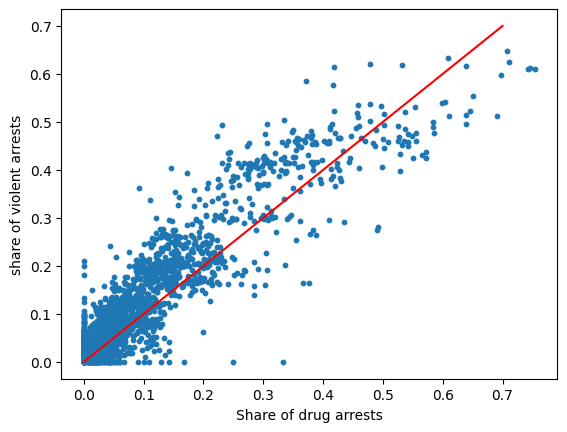

In [23]:
import matplotlib.pyplot as plt

plt.scatter(
    merged_df[merged_df["RACE"] == "Black"]["share_drug_arrests"],
    merged_df[merged_df["RACE"] == "Black"]["share_violent_arrests"],
    s=10,
)
plt.plot([0, 0.7], [0, 0.7], color="red")
plt.xlabel("Share of drug arrests")
plt.ylabel("share of violent arrests")
plt.show()

In [24]:
results["ex12_proportionate"] = "greater violent"

In [25]:
assert set(results.keys()) == {
    "ex4_num_rows",
    "ex5_collapsed_vars",
    "ex7_alameda_1980_share_violent_arrestees_black",
    "ex11_white_drug_share",
    "ex11_black_drug_share",
    "ex12_proportionate",
}